In [1]:
import numpy as np
import torch
from torch.nn.parameter import Parameter
from IPython.display import Image

# PCA with Pytorch.


Finding principal components using [Wikipedia Details](https://en.wikipedia.org/wiki/Principal_component_analysis#Details) and Pytorch.
<br><br><br>

We want to find principal components one by one, by finding the directions in which the data has the more variance.

## Step 1:
To find the first principal component of a data matrix **X**, we will use the last equation in:

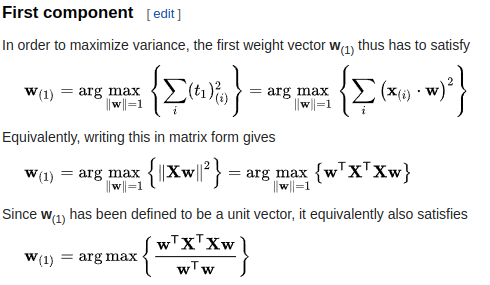

In [2]:
# source https://en.wikipedia.org/wiki/Principal_component_analysis#Details
Image(filename='screenshots/lossf.png') 

In [3]:
def variance_of_proj(x, w):
    """Computes the variance of x when projected on normalized w
    
    :param x: data matrix
    :param w: projection"""
    return w.T @ x.T @ x @ w / ((w.T @ w)[0][0])

## Step 2:

We will then remove the first component from the data matrix using the equation:

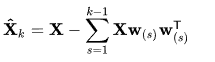

In [4]:
# source https://en.wikipedia.org/wiki/Principal_component_analysis#Details
Image(filename='screenshots/newcomps.png')

In [5]:
def remove_principal_component(x, w):
    """Removes principal component 'w' from the data matrix 'x'
    
    :param x: data matrix
    :param w: principal component"""
    with torch.no_grad():
        x = x - (x @ w @ w.T / ((w.T @ w)[0][0]))
    return x

We can then go back to Step 1 and compute new principal components. 
<br>

We will use a simple Pytorch loop to find the **w** vectors of Step 1:

In [6]:
def find_principal_component(x, n_ep = 300, tol = 1e-9):
    """Finds the principal component of the data matrix 'x'
    
    :param x: data matrix
    :param n_ep: number of epochs
    :param tol: convergence tolerance"""
    
    # randomly initializing the principal component
    w = Parameter(torch.normal(0, 1/torch.sqrt(torch.tensor(x.size()[1])), (x.size()[1], 1), device = x.device))
    
    # updating the principal component for 'n_ep' epochs, or until the variance of the projection of
    # x on w changed for less than 'tol' between two epochs
    lr = 1e-2
    opt = torch.optim.AdamW([w], lr = lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, lr, total_steps = n_ep, final_div_factor = 5)
    
    losses = []
    for ep in range(n_ep):
        loss = variance_of_proj(x, w)
        # pytorch minimizes losses, we want to maximize ours -> * (-1)
        (-1 * loss).backward()
        opt.step()
        sched.step()
        opt.zero_grad()
        losses.append(loss.item())
        
        if ep > 2:
            if losses[-1] - losses[-2] <= tol:
                break
    return w

## Let's try it out


To see if the idea works, we can do a simple test. Let's generate a random matrix, and remove it's first component using the above functions. We'll use numpy's SVD decomposition to check if the biggest singular value was indeed removed from the data:

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

x = torch.normal(mean = 0, std = 1, size = (10, 15), device = device)

Singular values before removing the first component:

In [8]:
x_numpy = x.cpu().numpy()
u, s, v = np.linalg.svd(x_numpy)
s

array([5.930982 , 5.590441 , 4.9011526, 4.5316796, 3.0485542, 2.7708528,
       2.33394  , 1.7223336, 1.0490218, 0.8797504], dtype=float32)

Let's see if the biggest singular value was set to 0:

In [9]:
w = find_principal_component(x)
x = remove_principal_component(x, w)

In [10]:
xnp = x.cpu().numpy()
u, s, v = np.linalg.svd(xnp)
s

array([5.642557  , 4.9021773 , 4.5317283 , 3.0491524 , 2.7708533 ,
       2.3350487 , 1.7223415 , 1.0490658 , 0.8818078 , 0.06419306],
      dtype=float32)

Not too bad, it was set to close to 0. Also, other singular values are nearly unchanged.


Let's visualize results of this implementation and sklearn's implementation on an easily separable dataset:

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
pc = PCA(2)

In [13]:
x1 = np.random.normal(loc = 1, scale = 2.0, size = (1000, 13))
x2 = np.random.normal(loc = -1, scale = 1.0, size = (1000, 13))
x = np.concatenate([x1, x2], axis = 0)

In [14]:
pca_comps = pc.fit_transform(x)

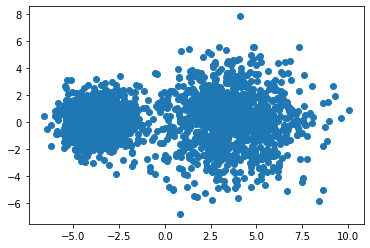

In [15]:
plt.scatter(x = pca_comps[:,0], y = pca_comps[:,1])

Sklearn's implementation easily finds the two trends in the dataset, let's check ours:

In [16]:
x = torch.tensor(x, dtype = torch.float, device = device)

In [17]:
x_comp = x.clone()

In [18]:
n_components = 2
comps = []
for c in range(n_components):
    w = find_principal_component(x_comp)
    x_comp = remove_principal_component(x_comp, w)
    with torch.no_grad():
        comps.append((x @ w).detach().cpu().numpy())

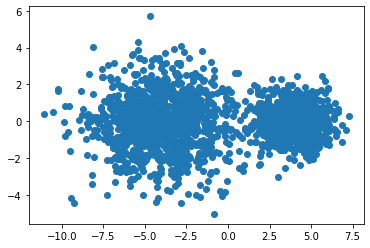

In [19]:
plt.scatter(x = comps[0], y = comps[1])

Nice! The sign of the 1st component looks to be flipped but that's ok, results are still useful.

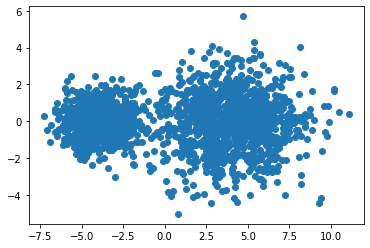

In [20]:
plt.scatter(x = -1 * comps[0], y = comps[1])

Let's confirm that it works as well when looping through the data by batch, for cases where datasets don't hold in ram:

In [21]:
def get_batch(x, i, bs = 128):
    return x[i*bs:(i+1)*bs]

def find_principal_component_by_batch(x, n_ep = 300, tol = 1e-9, bs = 128):
    """Finds the principal component of the data matrix 'x'
    
    :param x: data matrix
    :param n_ep: number of epochs
    :param tol: convergence tolerance"""
    
    # randomly initializing the principal component
    w = Parameter(torch.normal(0, 1/torch.sqrt(torch.tensor(x.size()[1])), (x.size()[1], 1), device = x.device))
    
    # updating the principal component for 'n_ep' epochs, or until the variance of the projection of
    # x on w changed for less than 'tol' between two epochs
    lr = 1e-2
    opt = torch.optim.AdamW([w], lr = lr)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, lr, total_steps = n_ep * bs, final_div_factor = 5)
    
    losses = []
    for ep in range(n_ep):
        n_batches = 1 + len(x) // 128
        batch_losses = []
        for b in range(n_batches):
            batch = get_batch(x, b)
            batch_loss = variance_of_proj(batch, w)
            # pytorch minimizes losses, we want to maximize ours -> * (-1)
            (-1 * batch_loss).backward()
            opt.step()
            sched.step()
            opt.zero_grad()
            batch_losses.append(batch_loss.item())
        losses.append(np.mean(batch_losses))
        
        if ep > 2:
            if losses[-1] - losses[-2] <= tol:
                break
    return w

In [22]:
x1 = np.random.normal(loc = 1, scale = 2.0, size = (1000, 13))
x2 = np.random.normal(loc = -1, scale = 1.0, size = (1000, 13))
x = np.concatenate([x1, x2], axis = 0)

In [23]:
pca_comps = pc.fit_transform(x)

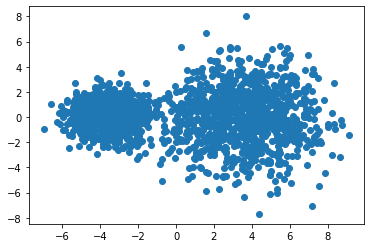

In [24]:
plt.scatter(x = pca_comps[:,0], y = pca_comps[:,1])

In [25]:
x = torch.tensor(x, dtype = torch.float, device = device)

In [26]:
x_comp = x.clone()

In [27]:
n_components = 2
comps = []
for c in range(n_components):
    w = find_principal_component_by_batch(x_comp)
    x_comp = remove_principal_component(x_comp, w)
    with torch.no_grad():
        comps.append((x @ w).detach().cpu().numpy())

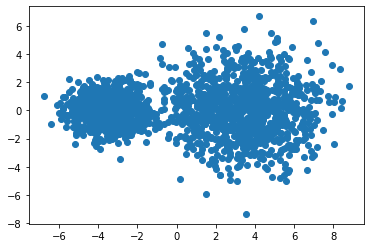

In [28]:
plt.scatter(x = comps[0], y = comps[1])

Nice. This time the sign of the component is flipped, but still ok

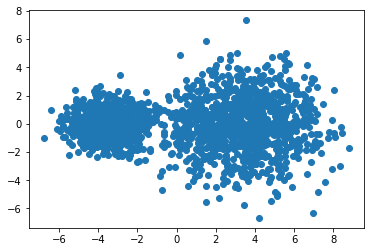

In [29]:
plt.scatter(x = comps[0], y = -1 * comps[1])